# Plot Recession Data
This data file contains approaches from EDA_Spike/Part_5_Model_All_v0_5_US.ipynb but using our pipeline data isntead of the original dataset. 

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from fredapi import Fred as fred
import time

from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

#import warnings
#warnings.filterwarnings('ignore')

# locally defined
from utils.training import get_training_data
from utils.constants import CLEAN_DATA_PATH, RAW_DATA_PATH

In [2]:
def get_recession_periods(df):
  '''
  Returns the first and last months of the recessionary period.
  ----------
  Parameters
  ----------
  df : data frame with stock price and regime indicator (recession: 1, normal: 0)
  '''
  dates = []
  recession = 1
  normal = 0

  regime = normal
  for i, j, k in zip(df.Regime, df.index, range(len(df))):
    if i == recession and regime == normal: # regime changes from normal to recession
      regime_span = []
      regime = recession
      regime_span.append(j)
    if i == normal and regime == recession: # regime changes from recession to normal
      regime = normal
      regime_span.append(df.index[k-1])
      dates.append(regime_span)
    if i == recession and j == df.index[-1]:
      regime_span.append(j)
  return dates


# use the cleaned dataset as the basis
df_cleaned = pd.read_csv(CLEAN_DATA_PATH+'merged.csv', index_col=0, parse_dates=True)

# Create recession spans and sample range for plots
recession_df = df_cleaned[['Regime']]
#recession_df.set_index('Date', inplace = True)
rec_spans = get_recession_periods(recession_df)
sample_range = pd.date_range(start = recession_df.index[0], end = recession_df.index[-1], freq = "MS")

### Now use split data to calculate probabilities

In [3]:
data = get_training_data(target='Regime', feature_type=None,  verbose=False, split_type='date', smote=False)

# get test/train sets
X_train, y_train = data["X_train"], data["y_train"].values.ravel()          
X_test, y_test = data["X_test"], data["y_test"].values.ravel()

X_train.shape

(309, 2373)

In [6]:
def plot_recession_probabilities(model, name):
  '''
  Returns a plot of the estimated probability of recession
  ----------
  Parameters
  ----------
  model: fitted model
  name: model name (string)
  '''
  # Get probability predictions on the selected training and test data
  prob_predictions_train = model.predict_proba(X_train)
  prob_predictions_test = model.predict_proba(X_test)

  # Concatenate probability predictions from training and test data
  prob_predictions = np.concatenate([prob_predictions_train, prob_predictions_test])

  # Plot the recession prediction probabilities over time
  plt.figure(figsize=(20, 5))
  plt.plot(sample_range.to_series().values, prob_predictions)

  # Add shaded regions to indicate recession spans
  for i in range(len(rec_spans)):
      plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')

  # Add a dashed line at y=0.5 for reference
  plt.axhline(y=0.5, color='r', ls='dashed', alpha=0.5)

  # Set plot title, x-axis label, and y-axis label
  plt.title(f'Recession Prediction Probabilities with {name}')
  plt.xlabel('Time')
  plt.ylabel('Recession Probability')
  plt.show()

  print(len(sample_range.to_series().values))
  print(len(prob_predictions))

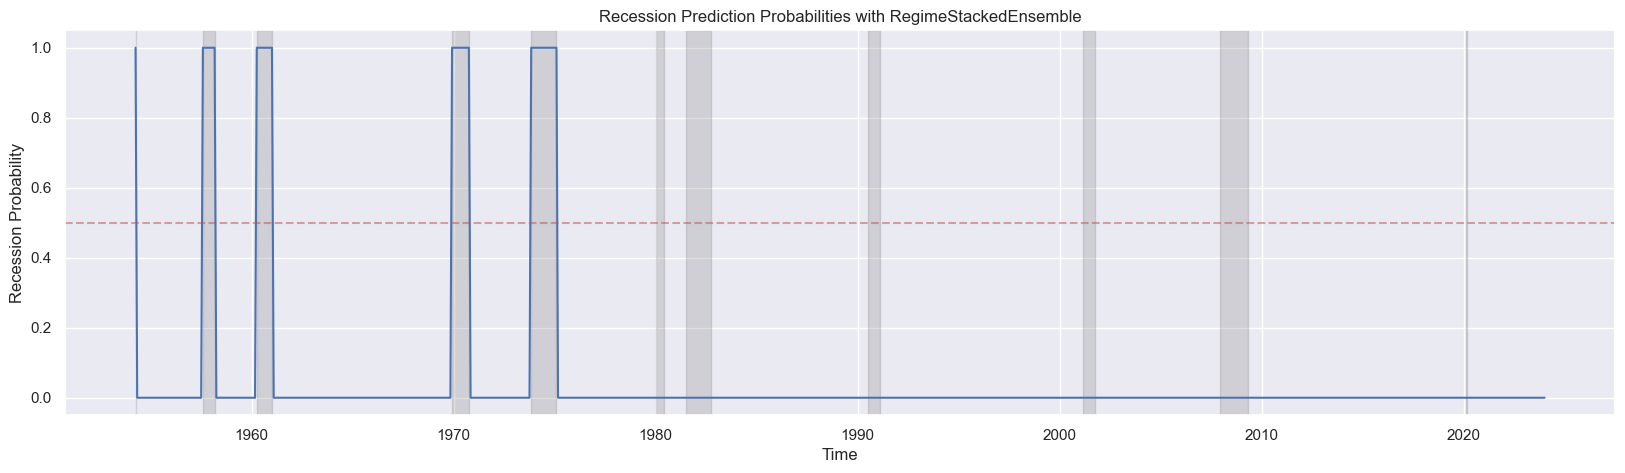

838
838


In [7]:
# Create and fit a logistic regression model
from stacked_ensemble import RegimeStackedEnsemble

model = RegimeStackedEnsemble(verbose=False)
model.fit(X_train, y_train)
plot_recession_probabilities(model, 'RegimeStackedEnsemble')